<center>
<h1><b>Lab 5</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 1, 2020</b></h3>
<hr>
</center>

## Units
- Mass
    - Solar Masses $\left[\mu=\frac{m}{M_{\text{Sun}}}\right]$
- Distance
    - Astronomical Units $\left[\lambda = \frac{l}{\text{AU}}\right]$
- Time
    - Days $\left[\tau=\frac{t}{d}\right]$

Therefore, the gravitational constant, becomes unitless with a value of: $G=2.959\times10^{-4}$

In [1]:
## Gravitational Constant In Our Units
G = 2.959e-4

## Imports

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from functools import partial
import matplotlib.pyplot as plt
from numpy.linalg import norm
from astroquery.jplhorizons import Horizons
from scipy.signal import find_peaks

In [3]:
plt.style.use('dark_background')

In [4]:
# mercury_info = Horizons(id=1,      id_type='majorbody')
# venus_info   = Horizons(id=2,      id_type='majorbody')
earth_info   = Horizons(id=3,      id_type='majorbody')
# mars_info    = Horizons(id=4,      id_type='majorbody')
jupiter_info = Horizons(id=5,      id_type='majorbody')
# saturn_info  = Horizons(id=6,      id_type='majorbody')
# uranus_info  = Horizons(id=7,      id_type='majorbody')
# neptune_info = Horizons(id=8,      id_type='majorbody')
# pluto_info   = Horizons(id=9,      id_type='majorbody')
sun_info     = Horizons(id=10,     id_type='majorbody')
sl2_info     = Horizons(id='137P', id_type='smallbody')
halley_info  = Horizons(id='90000033',   id_type='smallbody')

In [5]:
class Body:
    def __init__(self, mass, body):
        self.vecs = body.vectors()
        self.elems = body.elements()
        self.mass = mass
        self.pos = np.asarray([self.vecs['x'][0], self.vecs['y'][0], self.vecs['z'][0]])
        self.vel = np.asarray([self.vecs['vx'][0], self.vecs['vy'][0], self.vecs['vz'][0]])
        self.eccentricity = self.elems['e'][0]
        self.semi_major_axis = self.elems['a'][0]

In [6]:
# mercury = Body(     0.1660148e-6, mercury_info)
# venus   = Body(   2.081062723e-6,   venus_info)
earth   = Body( 3.00348959632e-6,   earth_info)
# mars    = Body(0.323237172221e-6,    mars_info)
jupiter = Body(    954.791915e-6, jupiter_info)
# saturn  = Body(   285.8856708e-6,  saturn_info)
# uranus  = Body(     43.662446e-6,  uranus_info)
# neptune = Body(     51.513848e-6, neptune_info)
# pluto   = Body(6.607677111904e-9,   pluto_info)
sl2     = Body(              0.0,     sl2_info)
halley  = Body(         1.16e-16,  halley_info)

In [7]:
def stationary_sun(t, y, mu):
    m1, m2 = mu
    x1, v1, x2, v2 = np.hsplit(y, 4)
    return np.hstack((
        v1,
        -G * (m2 * (x1 - x2) / norm(x1 - x2) ** 3.0 + x1 / norm(x1) ** 3.0),
        v2,
        -G * (m1 * (x2 - x1) / norm(x2 - x1) ** 3.0 + x2 / norm(x2) ** 3.0) ))

In [8]:
def two_body(t, y, mu):
    m1, m2 = mu
    x1, v1, x2, v2 = np.hsplit(y, 4)
    return np.hstack((
        v1,
        -G * (m2 * (x1 - x2) / norm(x1 - x2) ** 3.0),
        v2,
        -G * (m1 * (x2 - x1) / norm(x2 - x1) ** 3.0) ))

In [9]:
def three_body(t, y, mu):
    m1, m2, m3 = mu
    x1, v1, x2, v2, x3, v3 = np.hsplit(y, 6)
    return np.hstack((
        v1,
        -G * (m2 * (x1 - x2) / norm(x1 - x2) ** 3.0 + m3 * (x1 - x3) / norm(x1 - x3) ** 3.0),
        v2,
        -G * (m1 * (x2 - x1) / norm(x2 - x1) ** 3.0 + m3 * (x2 - x3) / norm(x2 - x3) ** 3.0),
        v3,
        -G * (m1 * (x3 - x1) / norm(x3 - x1) ** 3.0 + m2 * (x3 - x2) / norm(x3 - x2) ** 3.0)))

# Problem 1

Observe and display motion along circular, parabolic, and hyperbolic orbits in our Solar System, using the provided starter program (_planet_EC.py_) or your own equivalent code. First set initial conditions that would match the orbit of one of the solar system planets, and then calculate the (real) orbit of that planet. Next, change the initial velocity to take the planet to a hypothetical new orbit of a different type (if you start from a planet with a significantly elliptical orbit, such as Pluto or Mercury, this could be more challenging). Make sure to first theoretically estimate the necessary initial velocities that would be needed for circular and parabolic orbits. 

### Setup

In [10]:
mu = 1.0, earth.mass
df = partial(two_body, mu=mu)

In [11]:
state0_1 = np.hstack((
    np.array([0.0,0.0,0.0]),#sun.pos,
    np.array([0.0,0.0,0.0]),#sun.vel,
    earth.pos,
    earth.vel
    ))

state0_2 = np.hstack((
    np.array([0.0,0.0,0.0]),#sun.pos,
    np.array([0.0,0.0,0.0]),#sun.vel,
    earth.pos,
    np.sqrt(2.0)*earth.vel
    ))

state0_3 = np.hstack((
    np.array([0.0,0.0,0.0]),#sun.pos,
    np.array([0.0,0.0,0.0]),#sun.vel,
    earth.pos,
    np.sqrt(3.0)*earth.vel
    ))

tf_1 = 365.25
tf_2 = 500 * 365.25
tf_3 = 0.5 * 365.25

sol_1 = solve_ivp(df, [0.0, tf_1], state0_1, t_eval=np.linspace(0.0, tf_1, 10000), rtol=1.0e-6, atol=1.0e-6)
sol_2 = solve_ivp(df, [0.0, tf_2], state0_2, t_eval=np.linspace(0.0, tf_2, 10000), rtol=1.0e-6, atol=1.0e-6)
sol_3 = solve_ivp(df, [0.0, tf_3], state0_3, t_eval=np.linspace(0.0, tf_3, 100000), rtol=1.0e-6, atol=1.0e-6)

x1_1, v1_1, x2_1, v2_1 = np.vsplit(sol_1.y, 4)
x1_2, v1_2, x2_2, v2_2 = np.vsplit(sol_2.y, 4)
x1_3, v1_3, x2_3, v2_3 = np.vsplit(sol_3.y, 4)

t_1 = sol_1.t
t_2 = sol_2.t
t_3 = sol_3.t

earth_kinetic_1 = 0.5 * earth.mass * np.apply_along_axis(np.linalg.norm, 0, v2_1) ** 2
earth_kinetic_2 = 0.5 * earth.mass * np.apply_along_axis(np.linalg.norm, 0, v2_2) ** 2
earth_kinetic_3 = 0.5 * earth.mass * np.apply_along_axis(np.linalg.norm, 0, v2_3) ** 2

earth_potential_1 = - G / np.apply_along_axis(np.linalg.norm, 0, x2_1 - x1_1)
earth_potential_2 = - G / np.apply_along_axis(np.linalg.norm, 0, x2_2 - x1_2)
earth_potential_3 = - G / np.apply_along_axis(np.linalg.norm, 0, x2_3 - x1_3)

sun_kinetic_1 = 0.5 * 1.0 * np.apply_along_axis(np.linalg.norm, 0, v1_1) ** 2
sun_kinetic_2 = 0.5 * 1.0 * np.apply_along_axis(np.linalg.norm, 0, v1_2) ** 2
sun_kinetic_3 = 0.5 * 1.0 * np.apply_along_axis(np.linalg.norm, 0, v1_3) ** 2

sun_potential_1 = - G / np.apply_along_axis(np.linalg.norm, 0, x1_1 - x2_1)
sun_potential_2 = - G / np.apply_along_axis(np.linalg.norm, 0, x1_2 - x2_2)
sun_potential_3 = - G / np.apply_along_axis(np.linalg.norm, 0, x1_3 - x2_3)

total_energy_1 = earth_kinetic_1 + earth_potential_1 + sun_kinetic_1 + sun_potential_1
total_energy_2 = earth_kinetic_2 + earth_potential_2 + sun_kinetic_2 + sun_potential_2
total_energy_3 = earth_kinetic_3 + earth_potential_3 + sun_kinetic_3 + sun_potential_3

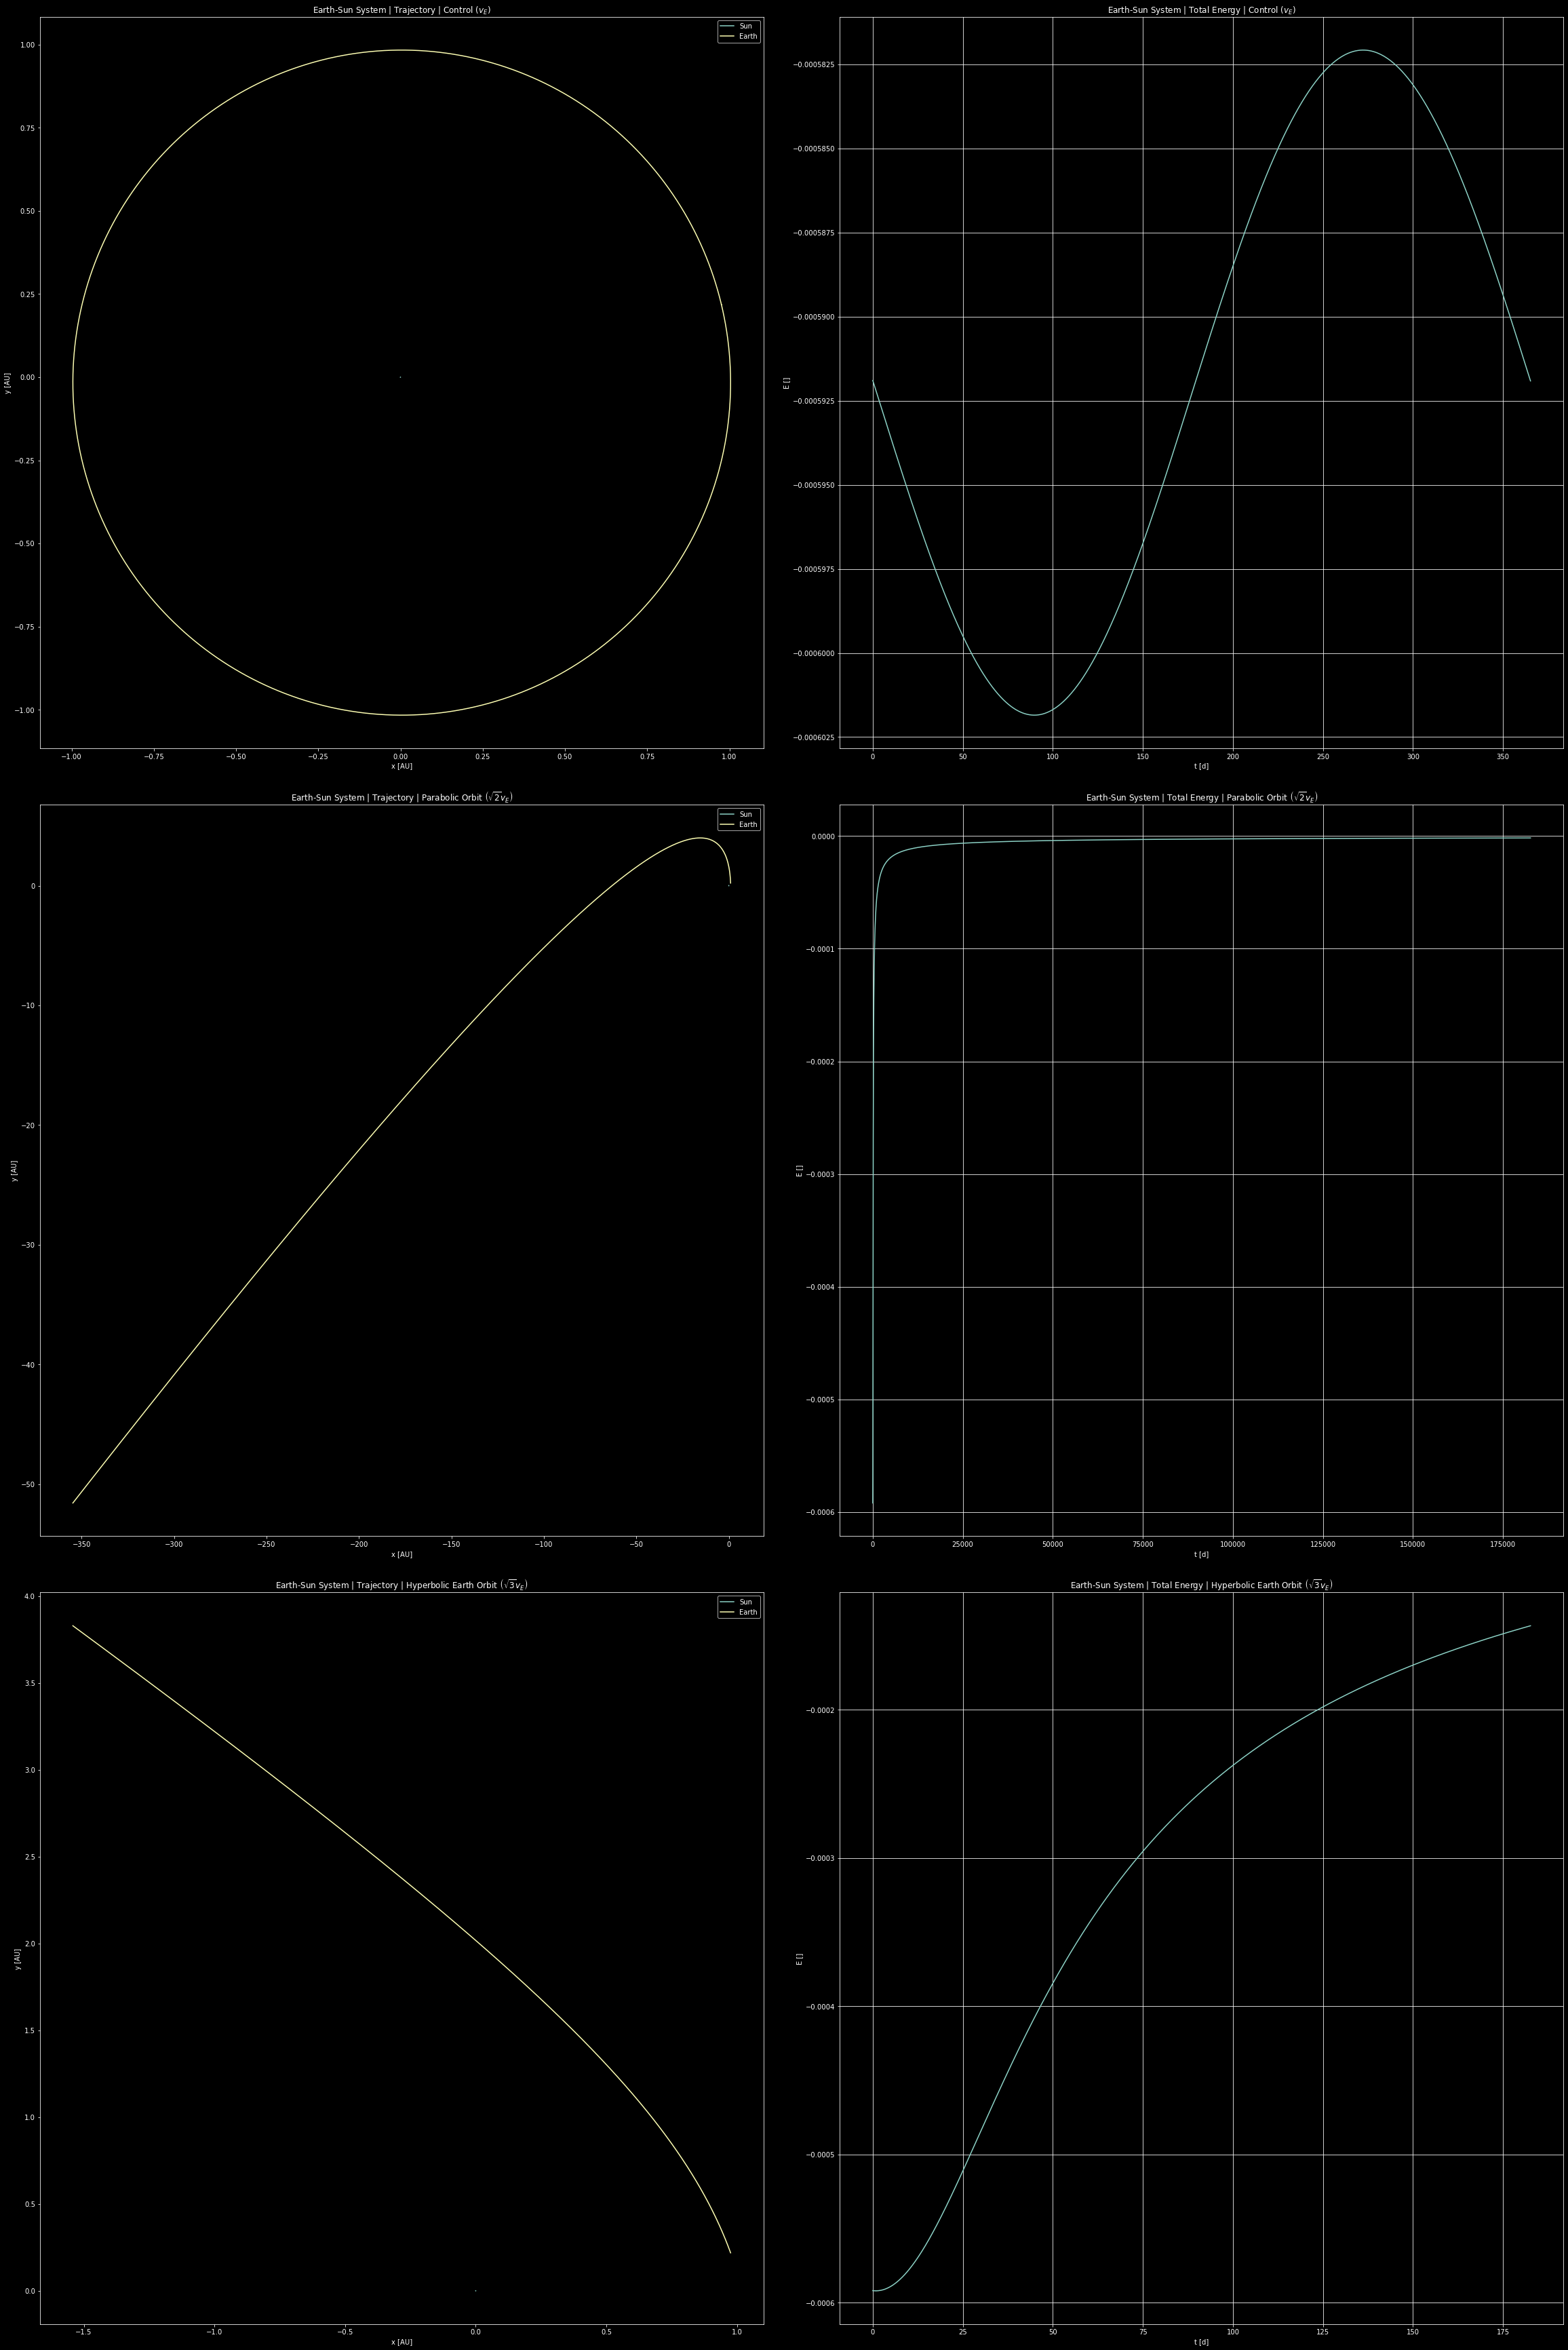

In [12]:
fig, axs = plt.subplots(3,2,figsize=(32,48), constrained_layout=True)

axs[0, 0].plot(x1_1[0,:], x1_1[1,:], label='Sun')
axs[0, 0].plot(x2_1[0,:], x2_1[1,:], label='Earth')
axs[0, 0].set_title(r'Earth-Sun System | Trajectory | Control $\left(v_E\right)$')
axs[0, 0].legend()
axs[0, 0].set_xlabel('x [AU]')
axs[0, 0].set_ylabel('y [AU]')

axs[0, 1].plot(t_1, total_energy_1)
axs[0, 1].set_title(r'Earth-Sun System | Total Energy | Control $\left(v_E\right)$')
axs[0, 1].set_xlabel('t [d]')
axs[0, 1].set_ylabel('E []')
axs[0, 1].grid()

axs[1, 0].plot(x1_2[0,:], x1_2[1,:], label='Sun')
axs[1, 0].plot(x2_2[0,:], x2_2[1,:], label='Earth')
axs[1, 0].set_title(r'Earth-Sun System | Trajectory | Parabolic Orbit $\left(\sqrt{2}v_E\right)$')
axs[1, 0].legend()
axs[1, 0].set_xlabel('x [AU]')
axs[1, 0].set_ylabel('y [AU]')

axs[1, 1].plot(t_2, total_energy_2)
axs[1, 1].set_title(r'Earth-Sun System | Total Energy | Parabolic Orbit $\left(\sqrt{2}v_E\right)$')
axs[1, 1].set_xlabel('t [d]')
axs[1, 1].set_ylabel('E []')
axs[1, 1].grid()

axs[2, 0].plot(x1_3[0,:], x1_3[1,:], label='Sun')
axs[2, 0].plot(x2_3[0,:], x2_3[1,:], label='Earth')
axs[2, 0].set_title(r'Earth-Sun System | Trajectory | Hyperbolic Earth Orbit $\left(\sqrt{3}v_E\right)$')
axs[2, 0].legend()
axs[2, 0].set_xlabel('x [AU]')
axs[2, 0].set_ylabel('y [AU]')

axs[2, 1].plot(t_3, total_energy_3)
axs[2, 1].set_title(r'Earth-Sun System | Total Energy | Hyperbolic Earth Orbit $\left(\sqrt{3}v_E\right)$')
axs[2, 1].set_xlabel('t [d]')
axs[2, 1].set_ylabel('E []')
axs[2, 1].grid()

plt.savefig('./Lab5out_P1_Plot.pdf', dpi=1000)

# Problem 2

Repeat the orbit calculation but with values appropriate for a comet - specifically, the Shoemaker-Levy 2 that has a perihelion of 1.933 AU and eccentricity of 0.572. Obtain its period by keeping track of time in your simulation. Crosscheck the numerical result against the theoretical prediction for the period and also, if you can, against actual measurements. What about Halley’s comet with perihelion of 0.589 AU and eccentricity of 0.967?  Do these two comets follow Kepler’s third law, $\frac{T^2}{a^3}=\text{const.}$, according to your simulations? 

In [13]:
mu = 1.0, sl2.mass, halley.mass
df = partial(three_body, mu=mu)

state0 = np.hstack((
    np.array([0.0,0.0,0.0]),
    np.array([0.0,0.0,0.0]),
    sl2.pos,
    sl2.vel,
    halley.pos,
    halley.vel
    ))

tf = 150 * 365.25

sol = solve_ivp(df, [0.0, tf], state0, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1, v1, x2, v2, x3, v3 = np.vsplit(sol.y, 6)
t = sol.t

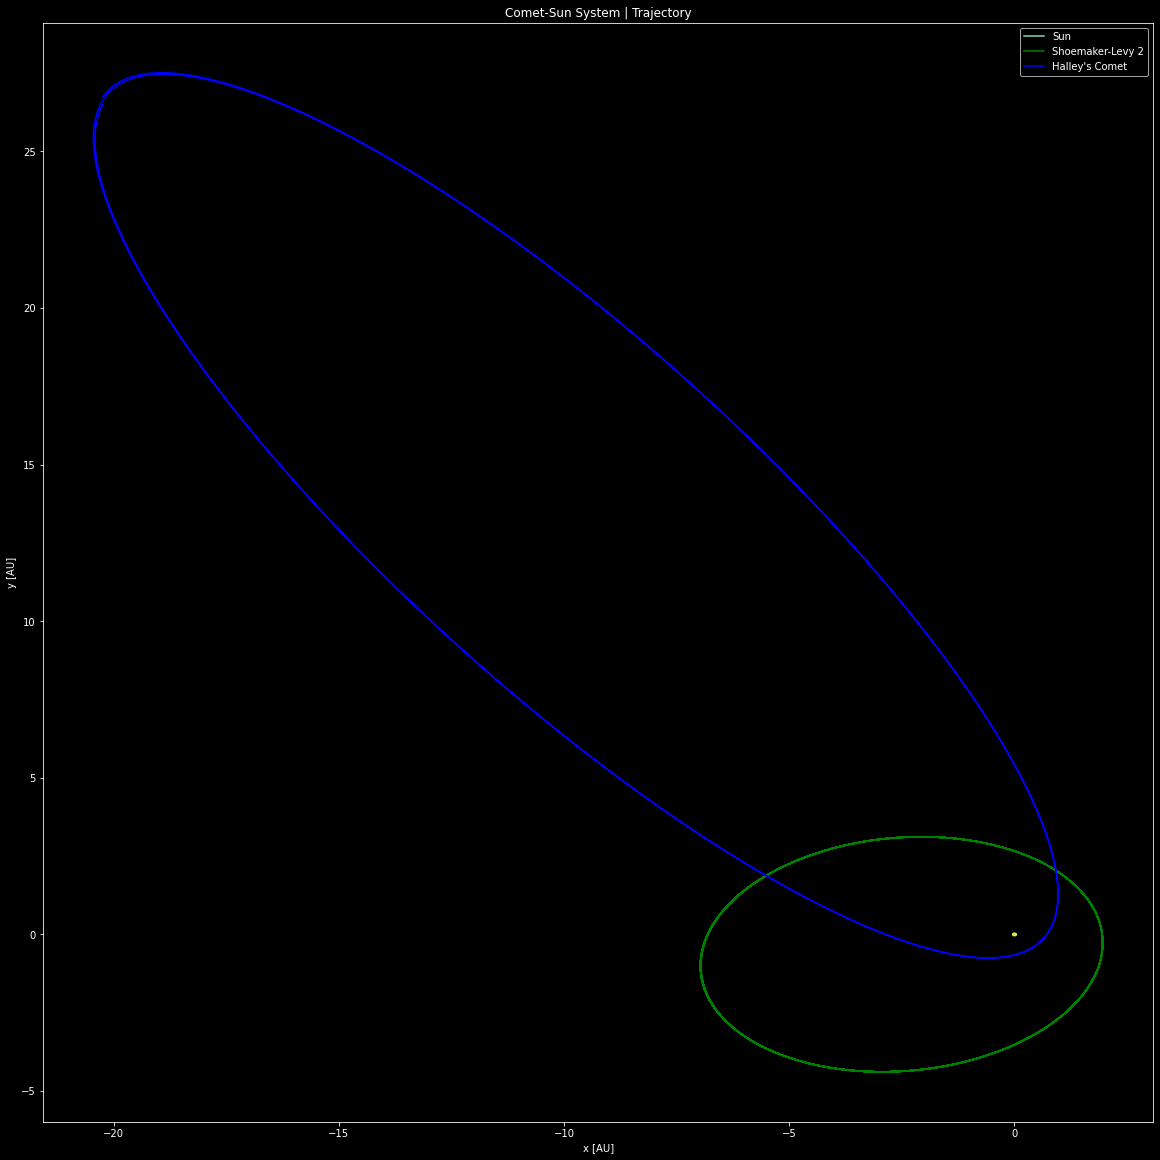

In [14]:
fig, axs = plt.subplots(1,1,figsize=(16,16), constrained_layout=True)

axs.add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs.plot(x1[0,:], x1[1,:], label='Sun')
axs.plot(x2[0,:], x2[1,:], label='Shoemaker-Levy 2', color='green')
axs.plot(x3[0,:], x3[1,:], label="Halley's Comet", color='blue')
axs.set_title(r'Comet-Sun System | Trajectory')

axs.legend()
axs.set_xlabel('x [AU]')
axs.set_ylabel('y [AU]')

plt.savefig('./Lab5out_P2_Plot.pdf', dpi=1000)

In [15]:
theta = np.vectorize(lambda x, y : np.arctan2(y,x))
theta2 = theta(x2[1,:], x2[2,:])
theta3 = theta(x3[1,:], x3[2,:])

peaks_idx_sl2, _ = find_peaks(theta2.flatten())
peaks_idx_halley, _ = find_peaks(theta3.flatten())

if len(peaks_idx_sl2) > 1:
    peaks_sl2 = np.take_along_axis(t, peaks_idx_sl2, 0)
    periods_sl2 = np.diff(peaks_sl2)
    period_sl2 = np.average(periods_sl2)

if len(peaks_idx_halley) > 1:
    peaks_halley = np.take_along_axis(t, peaks_idx_halley, 0)
    periods_halley = np.diff(peaks_halley)
    period_halley = np.average(periods_halley)

const_sl2 = period_sl2 ** 2 / sl2.semi_major_axis ** 3
const_halley = period_halley ** 2 / halley.semi_major_axis ** 3
print(const_sl2/const_halley)

1.002649683211725


$$\frac{\left(\frac{T^2}{a^3}\right)_{\text{SL2}}}{\left(\frac{T^2}{a^3}\right)_{\text{Halley}}}=1.002649690623257
$$

# Problem 3

Modify the starter program (_two_planets.py_) or create your own equivalent to observe and display how planet 2 affects (perturbs) the orbital motion of planet 1. The starter program assumes that the Sun is stationary, which is fine when the planets are much less massive than the Sun (true for the Solar System). Specifically, find out how much more massive Jupiter would need to be for its influence to make Earth's orbit visibly precess and eventually non-periodic. Also check how large Jupiter mass would be needed to eject(!) Earth from the Solar System. Jupiter’s orbit may be approximated as circular with radius 5.20 AU (the actual eccentricity is only about 0.048). Finally, verify how the results change, if at all, if you properly treat all 3 bodies (Sun, Earth, Jupiter) as mobile. Discussions in Section 4.2 of the textbook may be helpful for getting started. In particular, for elliptical orbits, 

$$v_{min}=\sqrt{\frac{GM_S}{a}}\sqrt{\frac{1-e}{1+e}\left(1+\frac{M_P}{M_S}\right)}$$

$$v_{max}=\sqrt{\frac{GM_S}{a}}\sqrt{\frac{1+e}{1-e}\left(1+\frac{M_P}{M_S}\right)}$$

$$r_{min}=a(1-e),\,\,r_{max}=a(1+e)$$

Also, do not forget to simplify things by using Solar system units: AU for distances and Earth year for time.

In [16]:
state0_1 = np.hstack((
    jupiter.pos, 
    jupiter.vel, 
    earth.pos, 
    earth.vel))

state0_2 = np.hstack((
    np.array([0.0, 0.0, 0.0]),#sun.pos,
    np.array([0.0, 0.0, 0.0]),#sun.vel, 
    state0_1))

tf = 11.862 * 365.25

df_1 = partial(stationary_sun, mu=(jupiter.mass, earth.mass))
sol_1 = solve_ivp(df_1, [0.0, tf], state0_1, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_1, v1_1, x2_1, v2_1 = np.vsplit(sol_1.y, 4)
t_1 = sol_1.t

df_2 = partial(stationary_sun, mu=(512*jupiter.mass, earth.mass))
sol_2 = solve_ivp(df_2, [0.0, tf], state0_1, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_2, v1_2, x2_2, v2_2 = np.vsplit(sol_2.y, 4)
t_2 = sol_2.t

df_3 = partial(stationary_sun, mu=(1500*jupiter.mass, earth.mass))
sol_3 = solve_ivp(df_3, [0.0, tf], state0_1, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_3, v1_3, x2_3, v2_3 = np.vsplit(sol_3.y, 4)
t_3 = sol_3.t

df_4 = partial(three_body, mu=(1.0, jupiter.mass, earth.mass))
sol_4 = solve_ivp(df_4, [0.0, tf], state0_2, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_4, v1_4, x2_4, v2_4, x3_4, v3_4 = np.vsplit(sol_4.y, 6)
t_4 = sol_4.t

df_5 = partial(three_body, mu=(1.0, 128.0*jupiter.mass, earth.mass))
sol_5 = solve_ivp(df_5, [0.0, tf], state0_2, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_5, v1_5, x2_5, v2_5, x3_5, v3_5 = np.vsplit(sol_5.y, 6)
t_5 = sol_5.t

df_6 = partial(three_body, mu=(1.0, 1500.0*jupiter.mass, earth.mass))
sol_6 = solve_ivp(df_6, [0.0, tf], state0_2, t_eval=np.linspace(0.0, tf, 10000), rtol=1.0e-6, atol=1.0e-6)
x1_6, v1_6, x2_6, v2_6, x3_6, v3_6 = np.vsplit(sol_6.y, 6)
t_6 = sol_6.t

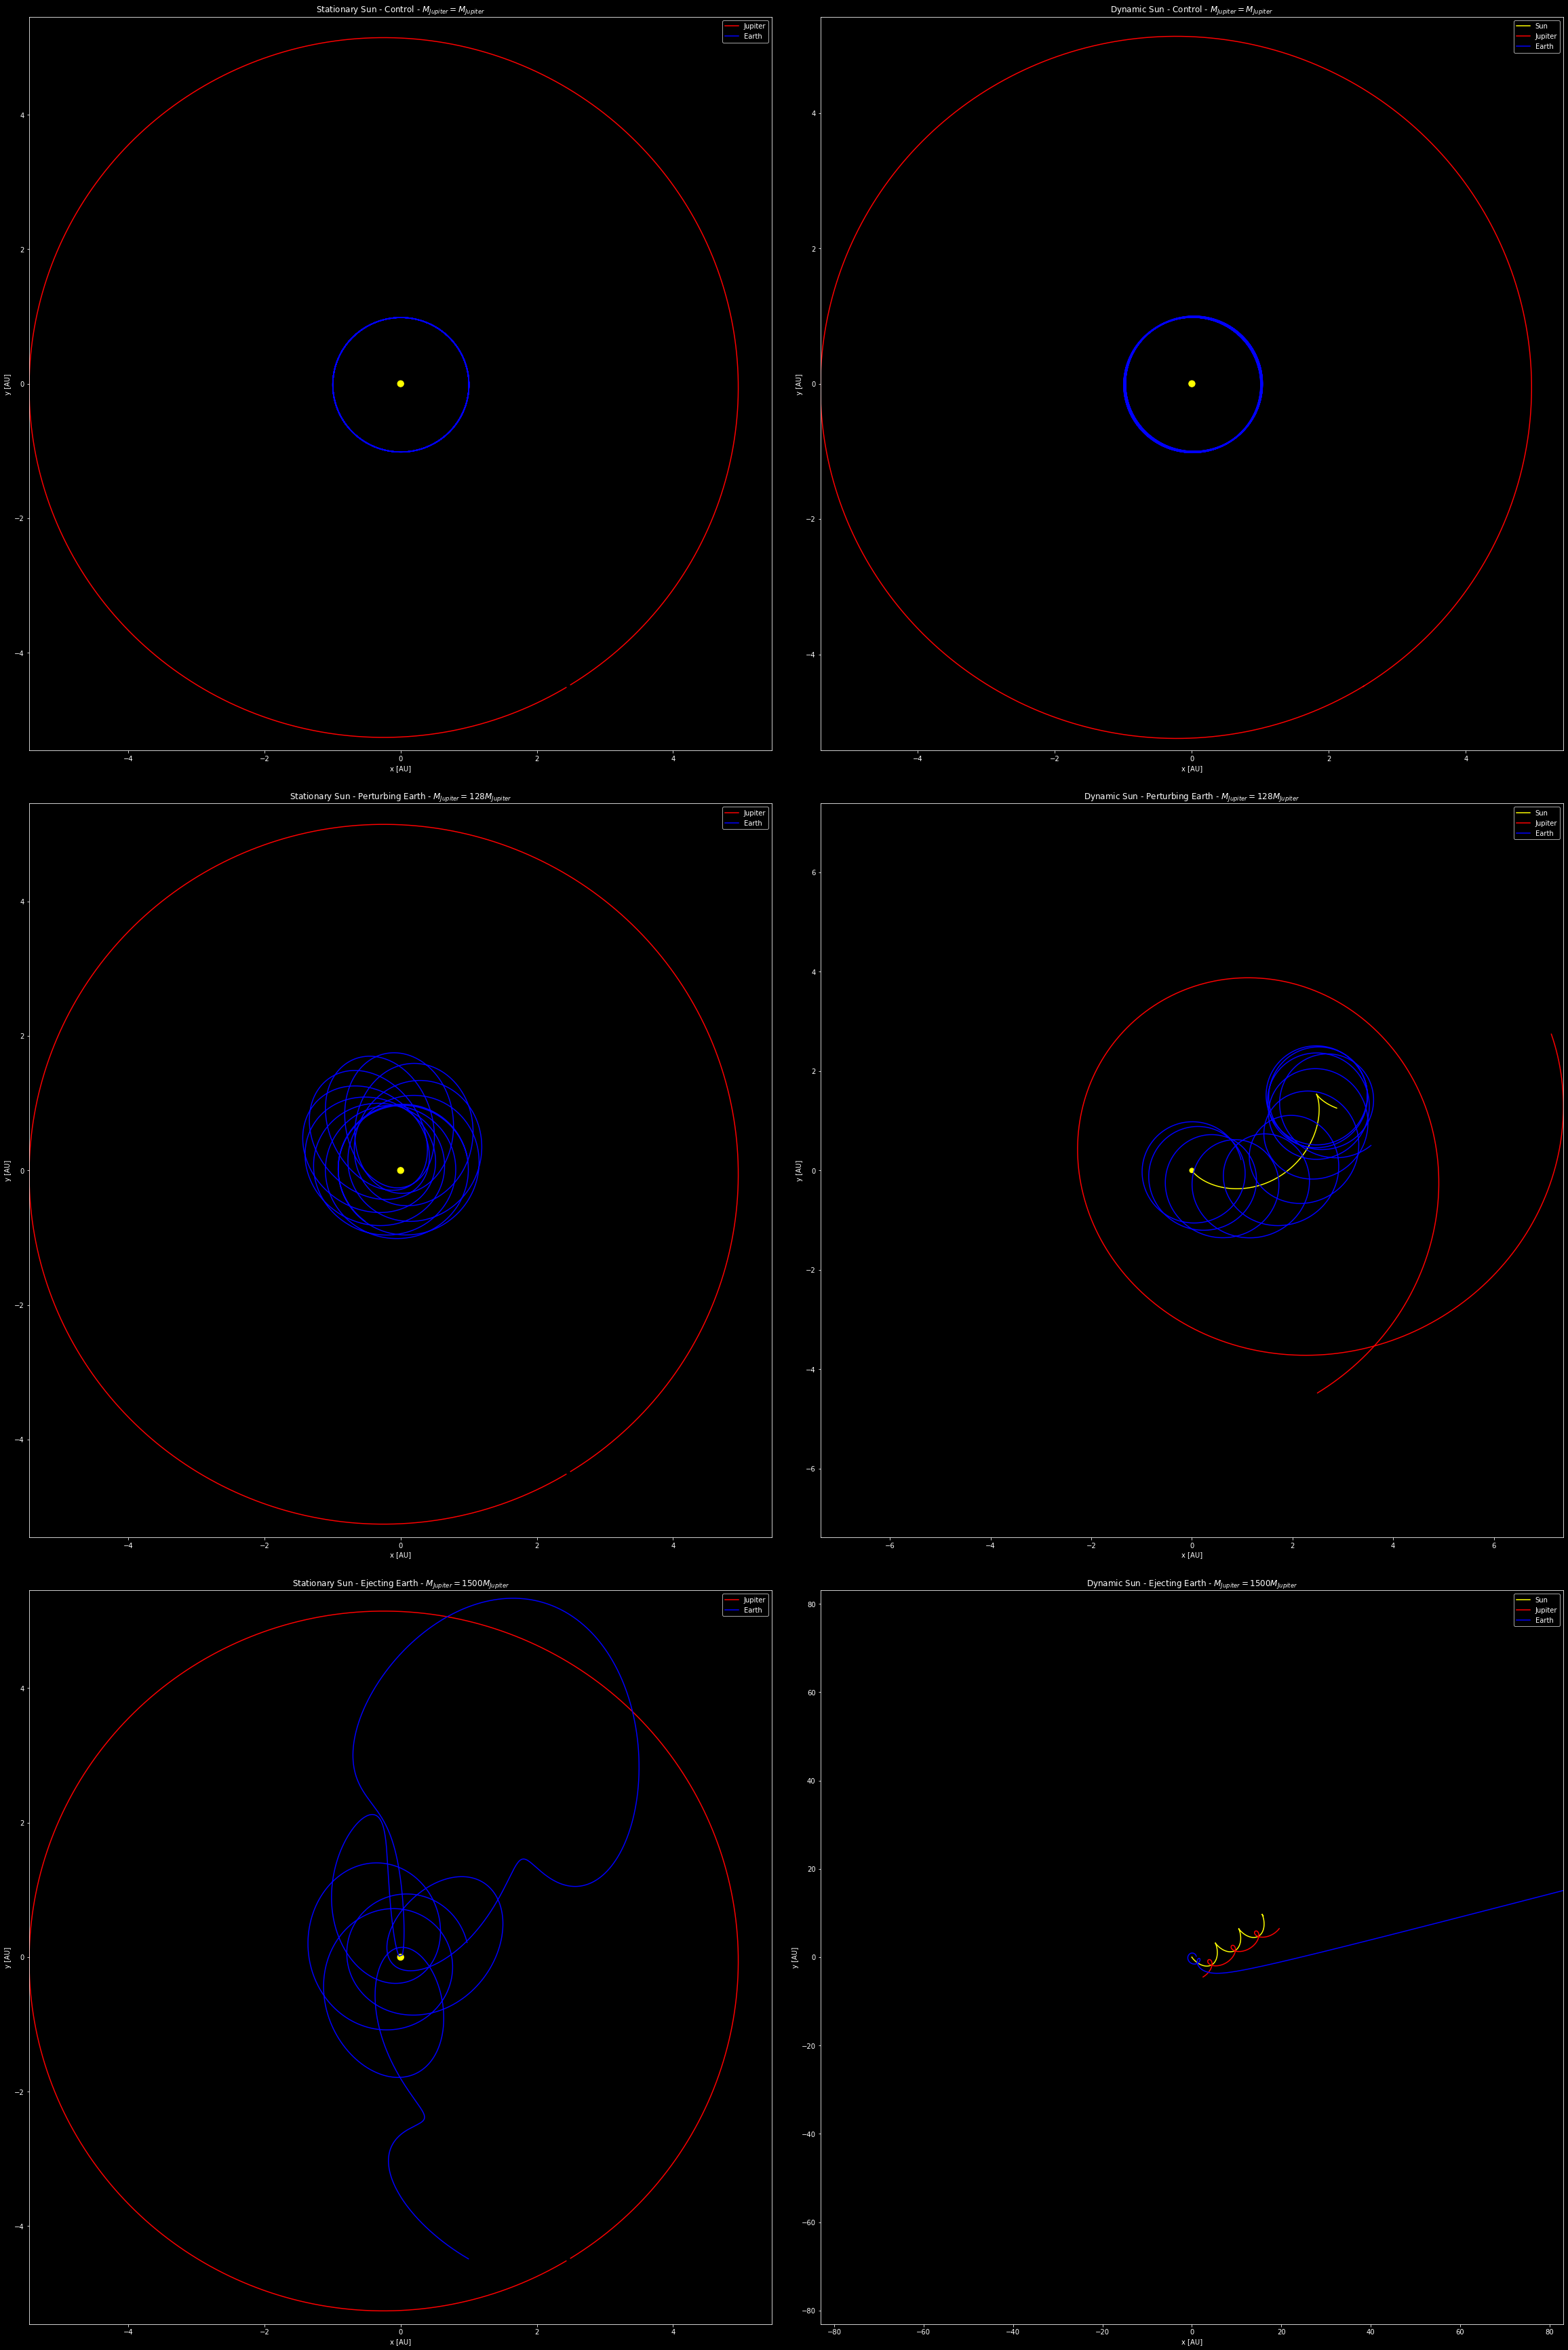

In [17]:
fig, axs = plt.subplots(3,2,figsize=(32,48), constrained_layout=True)

bound = max(np.abs(np.concatenate((x1_1,x2_1)).flatten()))
axs[0, 0].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[0, 0].set_title(r'Stationary Sun - Control - $M_{Jupiter}=M_{Jupiter}$')
axs[0, 0].plot(x1_1[0,:], x1_1[1,:], label='Jupiter', color='red')
axs[0, 0].plot(x2_1[0,:], x2_1[1,:], label='Earth', color='blue')
axs[0, 0].set_xlim(-bound, bound)
axs[0, 0].set_ylim(-bound, bound)
axs[0, 0].set_xlabel('x [AU]')
axs[0, 0].set_ylabel('y [AU]')
axs[0, 0].legend()

bound = max(np.abs(np.concatenate((x1_2,x2_2)).flatten()))
axs[1, 0].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[1, 0].set_title(r'Stationary Sun - Perturbing Earth - $M_{Jupiter}=128M_{Jupiter}$')
axs[1, 0].plot(x1_2[0,:], x1_2[1,:], label='Jupiter', color='red')
axs[1, 0].plot(x2_2[0,:], x2_2[1,:], label='Earth', color='blue')
axs[1, 0].set_xlim(-bound, bound)
axs[1, 0].set_ylim(-bound, bound)
axs[1, 0].set_xlabel('x [AU]')
axs[1, 0].set_ylabel('y [AU]')
axs[1, 0].legend()

bound = max(np.abs(np.concatenate((x1_3,x2_3)).flatten()))
axs[2, 0].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[2, 0].set_title(r'Stationary Sun - Ejecting Earth - $M_{Jupiter}=1500M_{Jupiter}$')
axs[2, 0].plot(x1_3[0,:], x1_3[1,:], label='Jupiter', color='red')
axs[2, 0].plot(x2_3[0,:], x2_3[1,:], label='Earth', color='blue')
axs[2, 0].set_xlim(-bound, bound)
axs[2, 0].set_ylim(-bound, bound)
axs[2, 0].set_xlabel('x [AU]')
axs[2, 0].set_ylabel('y [AU]')
axs[2, 0].legend()

bound = max(np.abs(np.concatenate((x1_4,x2_4,x3_4)).flatten()))
axs[0, 1].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[0, 1].set_title(r'Dynamic Sun - Control - $M_{Jupiter}=M_{Jupiter}$')
axs[0, 1].plot(x1_4[0,:], x1_4[1,:], label='Sun', color='yellow')
axs[0, 1].plot(x2_4[0,:], x2_4[1,:], label='Jupiter', color='red')
axs[0, 1].plot(x3_4[0,:], x3_4[1,:], label='Earth', color='blue')
axs[0, 1].set_xlim(-bound, bound)
axs[0, 1].set_ylim(-bound, bound)
axs[0, 1].set_xlabel('x [AU]')
axs[0, 1].set_ylabel('y [AU]')
axs[0, 1].legend()

bound = max(np.abs(np.concatenate((x1_5,x2_5,x3_5)).flatten()))
axs[1, 1].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[1, 1].set_title(r'Dynamic Sun - Perturbing Earth - $M_{Jupiter}=128M_{Jupiter}$')
axs[1, 1].plot(x1_5[0,:], x1_5[1,:], label='Sun', color='yellow')
axs[1, 1].plot(x2_5[0,:], x2_5[1,:], label='Jupiter', color='red')
axs[1, 1].plot(x3_5[0,:], x3_5[1,:], label='Earth', color='blue')
axs[1, 1].set_xlim(-bound, bound)
axs[1, 1].set_ylim(-bound, bound)
axs[1, 1].set_xlabel('x [AU]')
axs[1, 1].set_ylabel('y [AU]')
axs[1, 1].legend()

bound = max(np.abs(np.concatenate((x1_6,x2_6,x3_6)).flatten()))
axs[2, 1].add_artist(plt.Circle((0, 0), 0.0465, color = "yellow"))
axs[2, 1].set_title(r'Dynamic Sun - Ejecting Earth - $M_{Jupiter}=1500M_{Jupiter}$')
axs[2, 1].plot(x1_6[0,:], x1_6[1,:], label='Sun', color='yellow')
axs[2, 1].plot(x2_6[0,:], x2_6[1,:], label='Jupiter', color='red')
axs[2, 1].plot(x3_6[0,:], x3_6[1,:], label='Earth', color='blue')
axs[2, 1].set_xlim(-bound, bound)
axs[2, 1].set_ylim(-bound, bound)
axs[2, 1].set_xlabel('x [AU]')
axs[2, 1].set_ylabel('y [AU]')
axs[2, 1].legend()

plt.savefig('./Lab5out_P3_Plot.pdf', dpi=1000)